# Importing Modules and Libraries Required

In [1]:
import numpy as np
import pandas as pd

# Stastical analysis libraries

from scipy.stats import probplot, chisquare

# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline

# Others

from tqdm import tqdm
import warnings
import miceforest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
warnings.filterwarnings('ignore')


# Data Importing and Cleaning

In [2]:
data = pd.read_csv('TrainingData.csv')
data.replace(["C", "L"], [0,1], inplace=True) #Replacing Credit and Lending Card with [0,1]
data = data.drop(columns=['application_key'])
data = data.apply(pd.to_numeric, errors='coerce') #Convering missing values place-holders like missing, na, N/A etc. into NaN

In [3]:
data.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar43,mvar44,mvar45,mvar46,mvar47,mvar48,mvar49,mvar50,mvar51,default_ind
0,1696.0,1.6541,0.000,0.0,0.0,0.0,6015.0,322.0,40369.0,18414.0,...,10.0,0.63899,NaN,0.0,0,10,770,4.0,3080.0,0
1,1846.0,0.8095,0.000,0.0,0.0,102.0,7532.0,3171.0,18234.0,13664.0,...,13.0,0.63836,NaN,NaN,1,732,437,5.0,2185.0,1
2,1745.0,0.4001,0.000,0.0,0.0,NaN,2536.0,NaN,NaN,2536.0,...,1.0,1.00000,NaN,0.0,0,89,795,4.0,3180.0,1
3,1739.0,0.2193,0.000,0.0,0.0,1982.0,26440.0,4955.0,20316.0,37013.0,...,3.0,0.53241,0.0,0.0,1,3,755,4.0,3020.0,0
4,1787.0,0.0118,0.225,0.0,0.0,5451.0,5494.0,5494.0,7987.0,4696.0,...,1.0,0.92665,NaN,NaN,1,5,425,4.0,1700.0,0


# Distribution of Missing Values

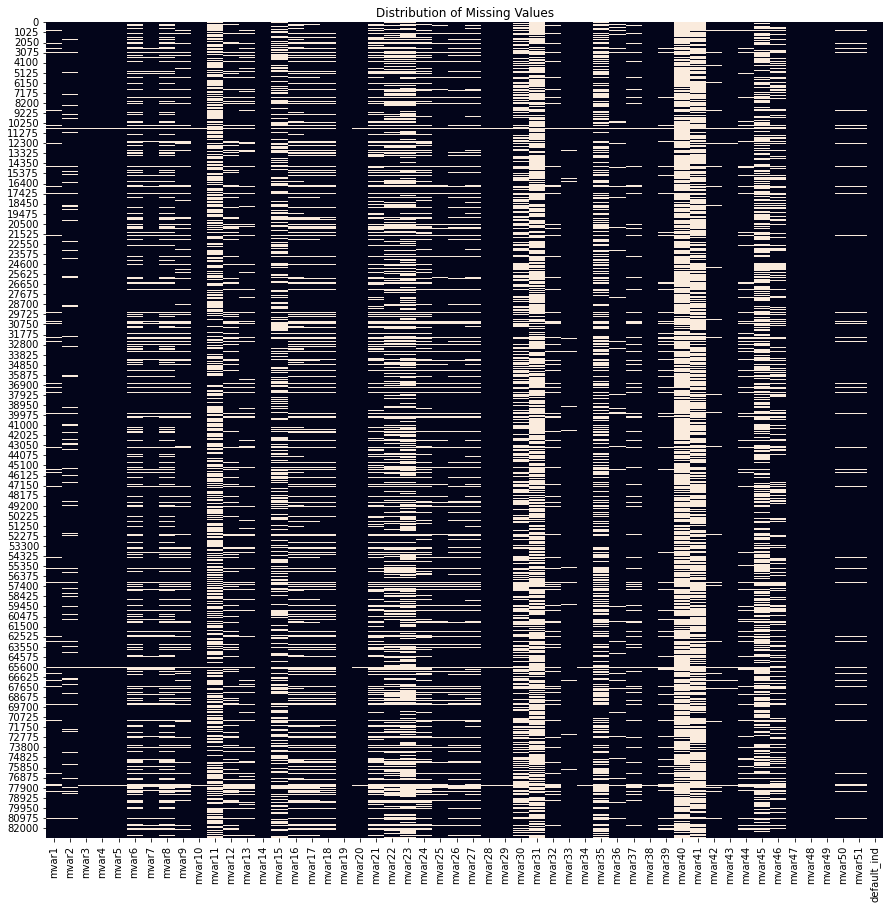

In [4]:
plt.figure(figsize=(15,15))
sns.heatmap(data.isnull(), cbar=False)
plt.title('Distribution of Missing Values')
plt.show()

**Some observations:**

- Some columns have missing values along the same row, hence, a possibility of correlation between them.
- 12 out of 52 features have more than 25\% of Data points missing.
- Few rows have almost all columns with missing values; dropping these rows will make some columns free from missing values, which is better suited for some models.
- The feature `Utilization of line on active education loans (%)` has the highest missing count of 78.4%. 

In [5]:
miss = []
columns = list(data)
for i in columns:
    count = data[i].isnull().sum()
    miss.append(count)

In [6]:
(sum(miss)/(52*len(data['mvar1'])))*100 #Average missing count in every feature

17.286399443929565

In [7]:
count = 0
for i in miss:
    if i>0.25*len(data['mvar1']) :
        count+=1
count #No of columns with more than 25% of data missing

12

# Correlation Plot

### Train Data

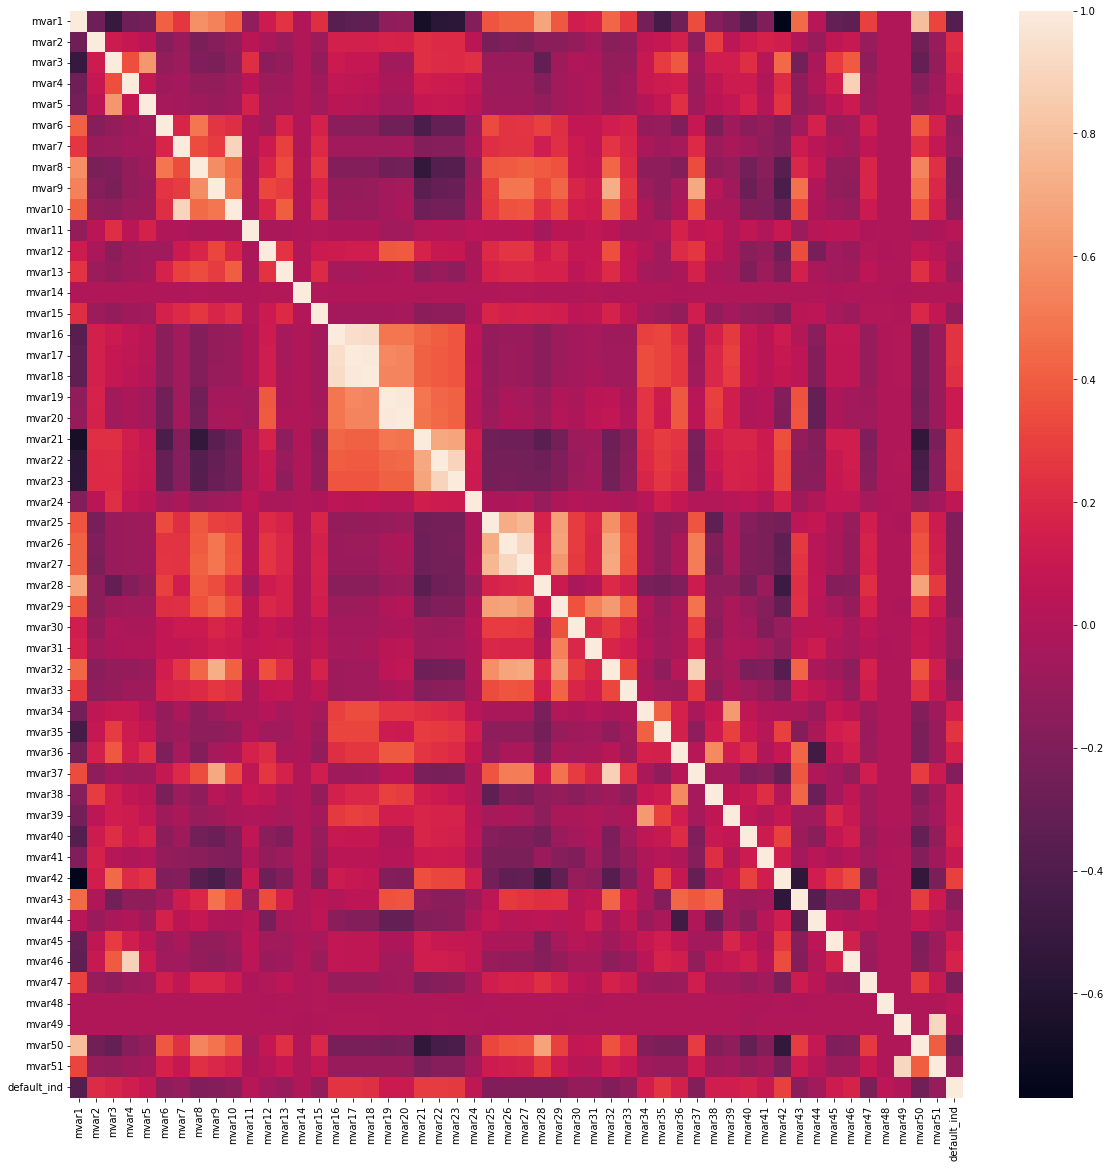

In [8]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

matrix = data.corr().round(2)
sns.heatmap(matrix, annot=False)
plt.show()

**Some observations:**

- It can be observed that `default_ind` only has very weak correlations with other features, hence, confirming no data leakage.
- For example, from the plot it is visible that, `Maximum of credit available on all active credit lines` and `Total amount of credit available on accepted credit lines` are correlated.
- The removal of correlated features helps reduce multicollinearity in certain models.

### Test Data

In [9]:
# test = pd.read_csv('testX.csv')
# test.replace(["C", "L"], [0,1], inplace=True) #Replacing Credit and Lending Card with [0,1]
# test = test.drop(columns=['application_key'])
# test = test.apply(pd.to_numeric, errors='coerce') #Convering missing values place-holders like missing, na, N/A etc. into NaN

In [10]:
# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(20)

# matrix = test.corr().round(2)
# sns.heatmap(matrix, annot=False)
# plt.show()

# Multicollinearity and VIF

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [12]:
data1 = data.fillna(data.mean())
vif_data = pd.DataFrame()
vif_data["feature"] = data1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data1.values, i)
                          for i in range(len(data1.columns))]
  
print(vif_data.sort_values('VIF'))

        feature         VIF
13       mvar14    1.001190
23       mvar24    1.114000
44       mvar45    1.201332
47       mvar48    1.256475
10       mvar11    1.326434
12       mvar13    1.411374
34       mvar35    1.539991
51  default_ind    1.739702
1         mvar2    1.751837
46       mvar47    1.792156
38       mvar39    1.805713
4         mvar5    1.860676
5         mvar6    1.952428
33       mvar34    2.244810
11       mvar12    2.282439
32       mvar33    2.349247
14       mvar15    2.773601
27       mvar28    2.890876
2         mvar3    3.528703
7         mvar8    3.701137
37       mvar38    4.419570
41       mvar42    4.440746
3         mvar4    4.721979
45       mvar46    4.751503
8         mvar9    5.356677
35       mvar36    6.923192
29       mvar30    6.974466
6         mvar7    7.056536
42       mvar43    7.955974
22       mvar23    8.711329
21       mvar22    9.186005
15       mvar16    9.403139
9        mvar10    9.774361
24       mvar25    9.856765
28       mvar29    9

# Miceforest Imputation

In [13]:
training = data.replace(np.nan,-1)  
training.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar43,mvar44,mvar45,mvar46,mvar47,mvar48,mvar49,mvar50,mvar51,default_ind
0,1696.0,1.6541,0.000,0.0,0.0,0.0,6015.0,322.0,40369.0,18414.0,...,10.0,0.63899,-1.0,0.0,0,10,770,4.0,3080.0,0
1,1846.0,0.8095,0.000,0.0,0.0,102.0,7532.0,3171.0,18234.0,13664.0,...,13.0,0.63836,-1.0,-1.0,1,732,437,5.0,2185.0,1
2,1745.0,0.4001,0.000,0.0,0.0,-1.0,2536.0,-1.0,-1.0,2536.0,...,1.0,1.00000,-1.0,0.0,0,89,795,4.0,3180.0,1
3,1739.0,0.2193,0.000,0.0,0.0,1982.0,26440.0,4955.0,20316.0,37013.0,...,3.0,0.53241,0.0,0.0,1,3,755,4.0,3020.0,0
4,1787.0,0.0118,0.225,0.0,0.0,5451.0,5494.0,5494.0,7987.0,4696.0,...,1.0,0.92665,-1.0,-1.0,1,5,425,4.0,1700.0,0


In [14]:
#data cleaning for miceforest imputer

diction_data = pd.read_csv("Data_Dictionary.csv")
typelist = diction_data["dtype"].tolist()

typelist.pop(0)
typelist.pop(-1)

training["default_ind"] = training["default_ind"].astype('category')

for i in range(1,52):
    colname = "mvar"+str(i)
    training[colname] = training[colname].astype(typelist[i-1])

training = training.replace(-1,np.nan)

X = training
y = training["default_ind"]

In [15]:
#Initialisation of miceforest imputer kernel

kernel = miceforest.ImputationKernel(
  data=X,
  save_all_iterations=True,
  random_state=8
)

kernel.mice(6,verbose=True)  #Kernel will perform 6 iteration in order to impute missing values in dataset

Initialized logger with name mice 1-6
Dataset 0
1  | mvar19 | mvar34 | mvar28 | mvar38 | mvar20 | mvar29 | mvar5 | mvar4 | mvar3 | mvar10 | mvar43 | mvar33 | mvar42 | mvar36 | mvar50 | mvar51 | mvar1 | mvar2 | mvar39 | mvar7 | mvar37 | mvar25 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30 | mvar23 | mvar45 | mvar11 | mvar41 | mvar31 | mvar40
2  | mvar19 | mvar34 | mvar28 | mvar38 | mvar20 | mvar29 | mvar5 | mvar4 | mvar3 | mvar10 | mvar43 | mvar33 | mvar42 | mvar36 | mvar50 | mvar51 | mvar1 | mvar2 | mvar39 | mvar7 | mvar37 | mvar25 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30 | mvar23 | mvar45 | mvar11 | mvar41 | mvar31 | mvar40
3  | mvar19 | mvar34 | mvar28 | mvar38 | mvar20 | mvar29 | mvar5 | mvar4 | mvar3 | mvar10 | mvar43 | mvar33 | mvar42 |

In [16]:
new_data_imputed = kernel.impute_new_data(X)
# Return a completed dataset
new_completed_data = new_data_imputed.complete_data(0)


# XGBoost Feature Importance

In [17]:
X_imp = new_completed_data.drop(["default_ind"],axis=1,inplace=False)
y_imp = y.to_numpy()
cols = X_imp.columns.tolist()

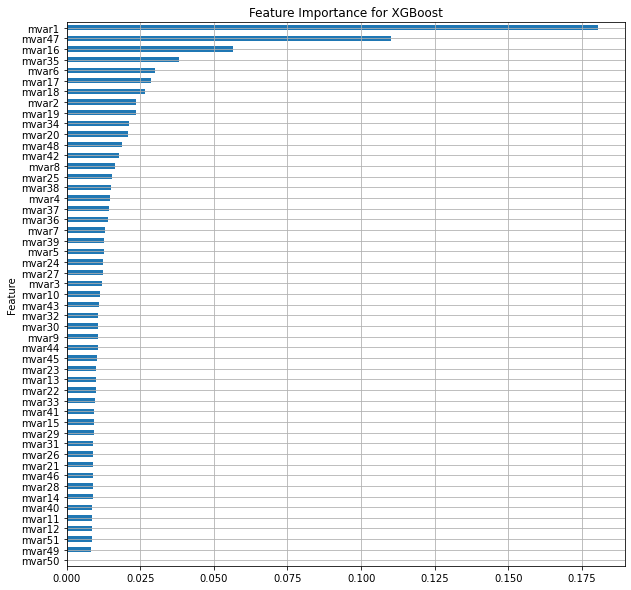

In [18]:
# Plotting feature importance for XGBoost model

xgb_imp_model = XGBClassifier()
xgb_imp_model.fit(X_imp,y_imp)
f_imps_xgb = xgb_imp_model.feature_importances_

table = pd.DataFrame({'Feature': cols, 'Importance': f_imps_xgb})
table = table.sort_values(by='Importance', ascending=True)
table = table.set_index(table['Feature'])
    
plt.figure(figsize=(10,10))
table['Importance'].plot.barh()
plt.title('Feature Importance for XGBoost')
plt.grid()
plt.show()

**Observations:**

- In this section, we will fit a `XGBoost` model on the dataset and analyze the importance of all features. For any feature its importance for a model is a measure of its influence on the model. 
- Features other than `mvar1` and `mvar47` don't show up as much in the feature importance curve. We can infer that these features explains majority of the variance.
- `mvar1-Credit worthiness Score` & `mvar47-Type of Credit Card applied for` are the most and second most important features respectively.

# PCA

In [19]:
# Principal Component Analysis
target = y_imp
X = X_imp

# Standard scaling of values for PCA
ss = StandardScaler()
X_scaled = ss.fit_transform(X_imp)

# Transforming dataset to PCA
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_scaled)
x, y = X_trans[:, 0], X_trans[:, 1]

# Explained variance values of top 20 principal components
pca_ev = PCA(n_components=20)
pca_ev.fit_transform(X_scaled)

components = np.array([19-i for i in range(20)])
variances = pca_ev.explained_variance_

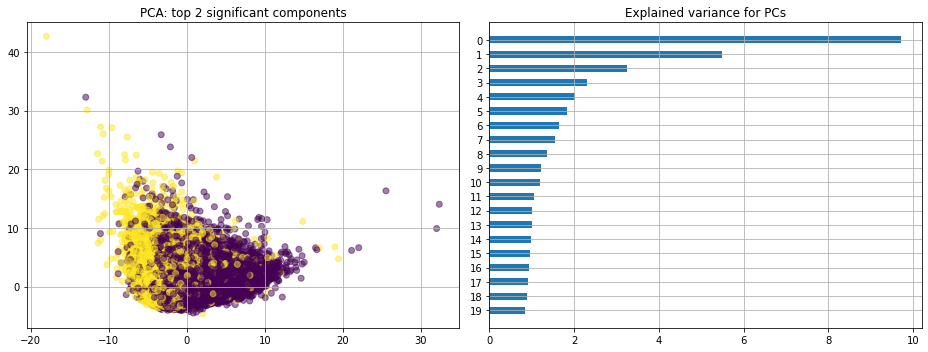

In [20]:
# Plotting
plt.figure(figsize=(13, 5))

# Scatter plot of data along top 2 significant PCs
plt.subplot(121)
plt.scatter(x, y, c=target, alpha=0.5)
plt.title('PCA: top 2 significant components')
plt.grid()

# Explained variance bar plot for top 20 PCs
plt.subplot(122)
plt.barh(components, width=variances, height=0.5)
plt.title("Explained variance for PCs")
plt.grid()
plt.yticks([i for i in range(20)], components)
plt.tight_layout()

plt.show()

**Observations:**

- In this section, we analyze the principal components of data.`PCA` helps us in dimensionality reduction and identifying the components which explains the variance effectively. We plotted data along 2 most significant Principal Components to check the presence of any visible decision boundary.
- We can observe that there is `no clear decision boundary`.
- There are lot of overlaps of data in the center part of the data cloud. Therefore even if we draw a decision boundary through the center part of the plot, there will be lot of `outliers` for the drawn decision boundary